# Prediccion de series temporales meteorológicas con redes neuronales LSTM

Analizaremos y evaluaremos el modelo entrenado para predecir algunas de las variables meteorológicas en cuanto a como realiza predicciones sobre las medidas de la base de datos.

In [1]:
# imports generales
import os
from datetime import datetime
import pickle
import glob

# imports relacionados a django y
from stations.models import Measurement, Prediction, Station
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# imports relacionados a data science
import pandas as pd
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error, max_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model, model_from_json
from keras.utils.vis_utils import plot_model

# imports de nuestro modulo geolomasexp usado para entrenar y predecir
from geolomasexp.configuration import LSTMTrainingScriptConfig
from geolomasexp.data import read_time_series_from_csv
from geolomasexp.feature import (
    get_dataset_from_series,
    get_interest_variable
)
from geolomasexp.model_hyperopt import (
    get_lstm_nnet_opt
)
from geolomasexp.model import (train_val_test_split)
from geolomasexp.model import predict_with_model
from geolomasexp.feature import series_to_supervised
import ipdb


# función para leer mediciones de la base de datos y devolverlas como un data frame
def read_time_series_from_db(
            sensor='A620',
            date_col='date',
            hr_col='hr',
            min_col='minute',
            numeric_var='temperature',
            sensor_var='inme',  # TODO : change this for station_code in all the script
            date_since=None,
            which_minutes = [0,15,30,45]
            ):

        # get all the measurements from this station
        measurements = Measurement.objects.filter(station=Station.objects.get(
            code=sensor).id)
        if date_since is not None:
            measurements = measurements.filter(datetime__gte=date_since)

        print(
            'Measurements to read from database for sensor {} with query \n{}'.
            format(sensor, measurements.query))

        # get a dataframe from the measurements
        dataset = pd.DataFrame(
            list(measurements.values('datetime', 'attributes')))
        print('Dataset from database of shape {}'.format(
            dataset.shape))
        
        # parse datetime column to get sepearae date, hr and minute columns
        dataset[date_col] = dataset.datetime.dt.date
        dataset[hr_col] = dataset.datetime.dt.hour
        dataset[min_col] = dataset.datetime.dt.minute
        # get the numeric var column parsing the json
        dataset[numeric_var] = dataset.attributes.apply(
            lambda x: x[numeric_var])
        dataset[sensor_var] = sensor

        # sort and re-index before returning
        dataset.sort_values([date_col, hr_col,min_col], inplace=True, ascending=True)
        dataset.reset_index(inplace=True)

        return dataset.loc[dataset.minute.isin(which_minutes)]
    

def get_database_data(djmodel = Prediction,sensor = 'A620',numeric_vars = ['temperature'],last_n_steps = -1):
    stat_id = Station.objects.get(code=sensor).id
    if last_n_steps > 0:
        records = djmodel.objects.filter(station=stat_id).order_by('-datetime')[:last_n_steps]
    else :
        records = djmodel.objects.filter(station=stat_id)
    dataset = None
    try:
        dataset = pd.DataFrame(list(records.values('datetime', 'attributes')))
        dataset['date'] = dataset.datetime.dt.date
        dataset['hr'] = dataset.datetime.dt.hour
        dataset['minute'] = dataset.datetime.dt.minute
        # get the numeric var column parsing the json
        for numeric_var in numeric_vars:
            dataset[numeric_var] = dataset.attributes.apply(lambda x: x[numeric_var])
        # sort and re-index before returning
        dataset.sort_values(['date', 'hr','minute'], inplace=True, ascending=True)
        dataset.reset_index(inplace=True)
    except Exception as e :
        print('Error trying to create dataset from DB {}'.format(e))

    return dataset



Using TensorFlow backend.
/home/munshkr/.local/share/virtualenvs/satlomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/munshkr/.local/share/virtualenvs/satlomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/munshkr/.local/share/virtualenvs/satlomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(

## Entrenamiento de modelos

Esta plataforma cuenta con un comando (`train_lstm`) que permite el entrenamiento de redes neuronales LSTM para poder predecir series temporales. Este comando leera `Measurement`s  de la base de datos y las usará para el entrenamiento. Por el momento el comando solo puede entrenar un modelo para una combinación de `Station` y variable meteorológica / atributo (temperatura,humedad, ...).

Para ejecutar este comando se debe hacer:
1. Ubicarse en la carpeta raíz del proyecto  `satlomas-back`
2. Para correrlo en background podemos ejecutar 

```
nohup python manage.py train_lstm_hyperopt archivo_de_configuracion.json 2011-01-01 0 >> archivo_para_logear.log 2>&1 &
```

El primer paremtro de est ecomando es un archivo que debe estar ubicado en una carpeta del llamada `config`. Este archivo debe contener la información de configuración del entrenamiento. Un ejemplo de su contenido es el siguiente

```
{
    "input_csv":"data/A620_temp.csv", 
    "output_log_file":"train_lstm_temp.log",
    "output_models_path":"models/", # aqui se guardaran los modelos resultantes
    "output_results_path":"results/", # aqui se guardarán los resultados
    "n_past_steps":24, # con esto decimos cuantos pasos para atras queremos mirar para entrenar la red
    "date_col":"date", 
    "hr_col":"hr",
    "numeric_var":"temperature", # esto indica cual es el attribute que necesitamos entrenar
    "sensor_var":"inme", 
    "target_sensor":"A620", # este es el nombre de la Station
    "early_stop_patience":100, # luego de cuantos epochs sin mejoras detener el entrenamiento
    "epochs":1000, # cuantos epochs (pasadas sobre todo el set de entrenamiento) máximos haremos
    "base_config":{
        "first_layer":{"mult":2,"dropout_rate":0.2,"dropout_range":[0,1]},
        "last_layer":{"mult":2,"dropout_rate":0.2,"dropout_range":[0,1]}
    },
    "mid_layers_config":{"n_layers":2,"mult":2,"dropout_rate":0.2,"dropout_range":[0,1]},
    "hyperopt_pars":{ # podemos poner mas de un valor en estos arreglos si queremos evaluar cual es la mejor opcion
        "mid_layers":[2], # cuantas capas intermedias queremos - 
        "mults":[2], # las neuronas de las capas intermedias seran mult * neronas de entrada
        "dropout_rate_range":[0.1,0.3],
        "max_evals":1
     },
    "model_loss":"mean_squared_error", # cual es la medida a optimizar
    "optimizer":"adam" 
}
```

El segundo parametro del comando de entrenamiento es una fecha desde cuando vamos a leer datos para entrenar, en el caso que tengamos demasiados y quisieramos restringirlo.

Finalmente el tercer parametro nos permite indicar cual minuto de la hora usaremos para sub-muestrear los datapoints. Por ejemplo si indicamos 0, decimos que solo usamos medidas de las horas en punto.

Cuando el comando finalice su ejecución deberiamos tener en la carpeta `models/` varios archivos y entre ellos uno con nombre similar a 

`models/esp:100_eps:1000_loss:mean_squared_error_opt:adam_pstps:24_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-05-09_18:11:10.model` 

este archivo representa esta instancia de entrenamiento y contiene el modelo y otra información para hacer predicciones. Cabe recordar que este archivo corresponde al modelo para **una estacion** y **un atributo** en particular. Por ejemplo en este caso sería un modelo para predecir *temperatura* de la estación *A620*.

Además tendremos en la carpeta `results/` un archivo `.csv` donde reportamos las medidas obtenidas.


## Entendiendo el modelo

Como primer paso debemos elegir cual es el modelo que queremos analizar. Para esto, debemos indicar la ubicación del archivo `.model` que tiene empaquetado no solo el modelo entrenado si no también el objeto `scaler` y otros objetos resultado del entrenamiento.

Recordemos que con la versión actual del sistema, tendremos un modelo por sensor y por variable. Por ejemplo podemos empezar analizando el modelo del sensor (ficticio) `A620` entrenado para predecir _temperaturas_ ya que es de quien tenemos datos en nuestra base.


In [74]:
model_package_name = '../models/esp:100_eps:1000_loss:mean_squared_error_opt:adam_pstps:24_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-05-09_18:11:10.model'

with open(model_package_name, 'rb') as file_pi:
    model_package = pickle.load(file_pi)
    
model = model_package['model']
print(model.summary())

print('Input shape del modelo {}'.format(model.input_shape))
print('Output shape del modelo {}'.format(model.output_shape))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 24, 48)            9600      
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 48)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 48)            18624     
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 48)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 48)            18624     
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 48)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 48)               

El modelo que analizaremos en primer lugar tiene 24 neuronas de entrada, es decir que fue entrenado mirando 24 pasos en el pasado. 

Además tiene 1 neurona de salida por lo que fué entrenado para predecir solo un paso al futuro. Debido a esto es que cuando lo usemos, tomaremos la prediccion hecha y la usaremos como parte del datapoint de entrada repetidamente para poder predecir más de un paso en el futuro. 

También se observa que tiene 4 capas intermedias de tipo `LSTM` con 48 neuronas en cada una. Además, cada `LSTM` está precedida por una `Dropout` para reducir un poco el overfitting.

Al final tenemos una capa densa.



## Evaluando algunas predicciones

### Temperatura

A continuación leeremos de la base de datos las mediciones almacenadas para el sensor correspondiente al modelo y aplicaremos el predictor para ver como se comportan sus estimaciones contra las medidas reales. 


En primer lugar leemos de la base de datos de la tabla `Measurement` para el sensor correspondiente y obtenemos un dataframe para seguir trabajando. 

Cabe aclarar que especificamos también que queremos la variable temperatura para trabajar y que solo tomaremos las medidas que correspondan con el minuto `0` de cada hora, ya que el modelo que usaremos se entrenó con datos sampleados a cada hora

In [80]:
dataframe_temp = read_time_series_from_db(sensor='A620',numeric_var='temperature',which_minutes=[0])
dataframe_temp.iloc[1500:1510]

Measurements to read from database for sensor A620 with query 
SELECT "stations_measurement"."id", "stations_measurement"."datetime", "stations_measurement"."station_id", "stations_measurement"."attributes" FROM "stations_measurement" WHERE "stations_measurement"."station_id" = 2
Dataset from database of shape (201600, 2)


,index,datetime,attributes,date,hr,minute,temperature,inme
6000,6864,2011-03-04 12:00:00+00:00,"{'pm25': 0.0, 'humidity': 85.0, 'pressure': 10...",2011-03-04,12,0,24.2,A620
6004,6868,2011-03-04 13:00:00+00:00,"{'pm25': 0.0, 'humidity': 81.0, 'pressure': 10...",2011-03-04,13,0,25.1,A620
6008,6872,2011-03-04 14:00:00+00:00,"{'pm25': 0.0, 'humidity': 82.0, 'pressure': 10...",2011-03-04,14,0,25.4,A620
6012,6876,2011-03-04 15:00:00+00:00,"{'pm25': 0.8, 'humidity': 81.0, 'pressure': 10...",2011-03-04,15,0,25.6,A620
6016,6880,2011-03-04 16:00:00+00:00,"{'pm25': 0.0, 'humidity': 70.0, 'pressure': 10...",2011-03-04,16,0,26.7,A620
6020,6884,2011-03-04 17:00:00+00:00,"{'pm25': 0.8, 'humidity': 68.0, 'pressure': 10...",2011-03-04,17,0,27.1,A620
6024,6888,2011-03-04 18:00:00+00:00,"{'pm25': 0.0, 'humidity': 66.0, 'pressure': 10...",2011-03-04,18,0,27.7,A620
6028,6892,2011-03-04 19:00:00+00:00,"{'pm25': 0.0, 'humidity': 82.0, 'pressure': 10...",2011-03-04,19,0,25.2,A620
6032,6896,2011-03-04 20:00:00+00:00,"{'pm25': 0.8, 'humidity': 88.0, 'pressure': 10...",2011-03-04,20,0,24.3,A620
6036,6900,2011-03-04 21:00:00+00:00,"{'pm25': 0.0, 'humidity': 91.0, 'pressure': 10...",2011-03-04,21,0,23.9,A620


Luego extraemos solo la columna de la temperatura para poder generar los datapoints para predecir a partir de ella

In [82]:
time_series_dset = get_interest_variable(dataframe_temp, 'inme','date', 'hr','temperature','A620')
time_series_dset.iloc[1500:1510]

temperature
date       hr             
2011-03-04 12         24.2
           13         25.1
           14         25.4
           15         25.6
           16         26.7
           17         27.1
           18         27.7
           19         25.2
           20         24.3
           21         23.9

Hasta este momento tenemos los datos en un formato de tabla pero debemos generar un dataset donde cada fila sea en realidad un valor y sus n pasos anteriores tal como se uso para entrenar. 

En otras palabras, cada fila de la nueva tabla será un datapoint, por lo tanto para este caso tiene que tener 24 valores de temperatura contiguos ya que la red espera 24 valores como entrada para predecir el valor número 25. 

In [83]:
scaler = model_package['scaler']

past_steps_train = model.input_shape[1]

# obtenemos los valores como una matriz
values = time_series_dset.values
# ensure all data is float
values = values.astype('float32')

scaled = scaler.transform(values)
scaled = pd.DataFrame(scaled,columns=time_series_dset.columns)# frame as supervised learning

reframed = series_to_supervised(scaled, past_steps_train, 1)
reframed.iloc[1000:1005]


,temperature_t-24,temperature_t-23,temperature_t-22,temperature_t-21,temperature_t-20,temperature_t-19,temperature_t-18,temperature_t-17,temperature_t-16,temperature_t-15,...,temperature_t-9,temperature_t-8,temperature_t-7,temperature_t-6,temperature_t-5,temperature_t-4,temperature_t-3,temperature_t-2,temperature_t-1,temperature_t
1024,0.824096,0.824096,0.800000,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,...,0.021687,0.021687,0.021687,0.021687,0.677108,0.732530,0.790361,0.021687,0.800000,0.809639
1025,0.824096,0.800000,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,...,0.021687,0.021687,0.021687,0.677108,0.732530,0.790361,0.021687,0.800000,0.809639,0.812048
1026,0.800000,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,...,0.021687,0.021687,0.677108,0.732530,0.790361,0.021687,0.800000,0.809639,0.812048,0.787952
1027,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,...,0.021687,0.677108,0.732530,0.790361,0.021687,0.800000,0.809639,0.812048,0.787952,0.768675
1028,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,0.021687,...,0.677108,0.732530,0.790361,0.021687,0.800000,0.809639,0.812048,0.787952,0.768675,0.715663


A continuación tomaremos muestras al azar del dataset y aplicarremos el modelo para predecir al futuro y comparar como fue la medición real contra lo predecido y tener una idea del error del modelo.

In [84]:
# particionar el dataset en trainset , validation set y test set
dataset_splits = train_val_test_split(reframed, past_steps_train,1, 'temperature')

Sampleamos datasets de futuro a pasado
(30225, 24) 30225 (30225,)
(30225, 24, 1) (30225,) (10075, 24, 1) (10075,) (10076, 24, 1) (10076,)


MAE : 4.700986054208544º - MaxE : 8.724689483642578º - Index of MaxE : 39
MAE : 4.089422543843587º - MaxE : 11.560478210449219º - Index of MaxE : 13
MAE : 5.202801863352458º - MaxE : 17.48322868347168º - Index of MaxE : 4
MAE : 16.63012640343772º - MaxE : 29.58396625518799º - Index of MaxE : 48
MAE : 4.265489604738024º - MaxE : 10.919900894165039º - Index of MaxE : 65
MAE : 6.418197578854031º - MaxE : 12.513975143432617º - Index of MaxE : 0
MAE : 12.143326384325823º - MaxE : 28.270414352416992º - Index of MaxE : 35
MAE : 3.393290056122674º - MaxE : 8.877269744873047º - Index of MaxE : 60
MAE : 16.061077495364266º - MaxE : 26.49240255355835º - Index of MaxE : 62
MAE : 5.6478196779886884º - MaxE : 11.621055603027344º - Index of MaxE : 19


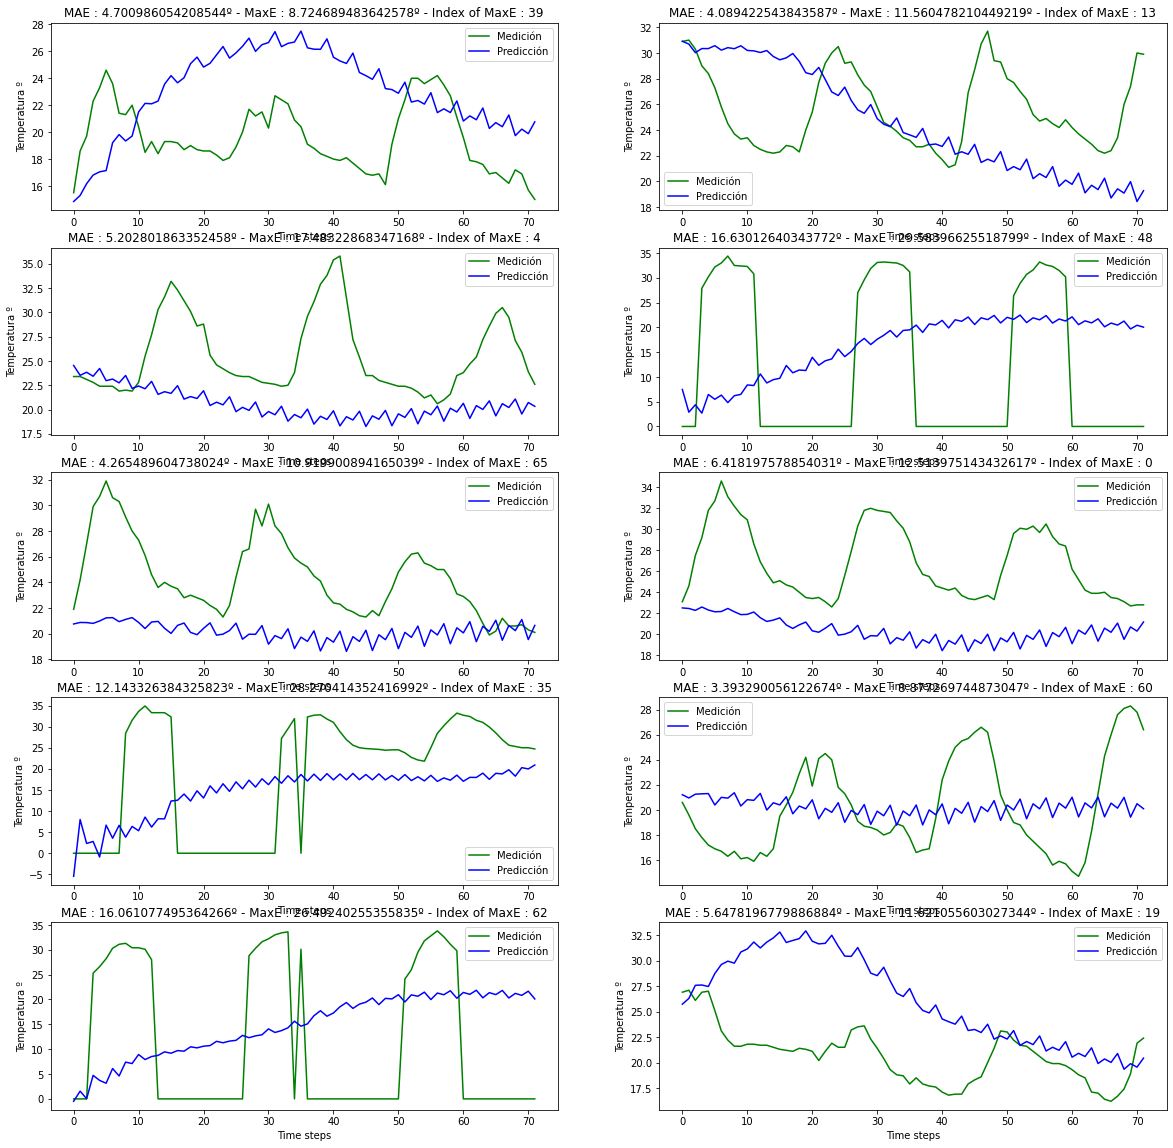

In [85]:

# usaremos el trainset
dset = dataset_splits['testset']

# del trainset extraemos las entradas X y salidas y
X = dset['X']
y = dset['y']

# vamos a predecir al futuro 72 horas
future_steps = 72

# acumulamos los errores medio y maximo
maes = []
maxes = []
errors = []

# TODO esto deberia ser una grilla de subplots o algo asi

rows = 5 
cols = 2
n = rows * cols
fig, axs = plt.subplots(rows, cols,figsize=(20,20))
# vamos a hacer n muestras al azar y predecir sobre ellas 
for row in range(rows):
    for col in range(cols):
        i = np.random.randint(0,X.shape[0]-future_steps-1)
        try:
            # obtener el datpoints
            datapoint = X[i,:,:]

            # obtenemos el valor real pero des-escalado
            true = scaler.inverse_transform(y[i:i+future_steps].reshape(1,future_steps))

            # aplicamos el predictor sobre el datapoint
            preds,_ = predict_with_model(datapoint,model_package_name,future_steps)

            pred_list = []
            for step in preds:
                pred_list.append(np.float64(step[0][0]))
            pred = np.array([pred_list])

            # obtenemos los errores
            error = pred - true
            errors.append(error[0])

            mae_ = mean_absolute_error(true[0],pred[0])
            maes.append(mae_)
            maxe_ = max_error(true[0],pred[0])
            maxes.append(maxe_)
            max_error_index = np.argmax(error[0])

            msg = 'MAE : {}º - MaxE : {}º - Index of MaxE : {}'.format(mae_,maxe_,max_error_index)
            
            # ploteamos el valor verdadero en verde y el predecido en azul
            #plt.figure()
            the_ax = axs[row,col]
            the_ax.plot(range(true.shape[1]),true[0],'g',label='Medición')
            the_ax.plot(range(pred.shape[1]),pred[0],'b',label='Predicción')
            the_ax.set_title(msg)
            the_ax.legend()
            the_ax.set_xlabel('Time steps')
            the_ax.set_ylabel('Temperatura º')
            #axs[row,col].show()
    
            print(msg)
        except Exception as e:
            print('Exception {}'.format(e))



Los gráficos anteriores muestran que al modelo le cuesta seguir a la medida real con exactitud.

El valor máximo y promedio de los 2 tipos de errores es el siguiente:

In [88]:
print('MAE promedio : {} grados'.format(np.mean(maes)))
print('MAE máximo : {} grados'.format(np.max(maes)))
print('Error maximo promedio : {} grados'.format(np.mean(maxes)))
print('Máximo Error maximo : {} grados'.format(np.max(maxes)))

MAE promedio : 7.855253766223582 grados
MAE máximo : 16.63012640343772 grados
Error maximo promedio : 16.604738092422487 grados
Máximo Error maximo : 29.58396625518799 grados


De esta evaluación podemos ver que si bién el error absoluto promedio no supera los 5 grados, podemos llegar a tener errores absolutos medios de hasta 16 grados.

Por otro lado el error máximo que podemos tener es de 30 grados lo que no es para nada bueno.

Vemos cual es el error absoluto que obtenemos para cada paso para tener una idea de si hay una tendencia de mayor error para algun paso determinado de la prediccion.

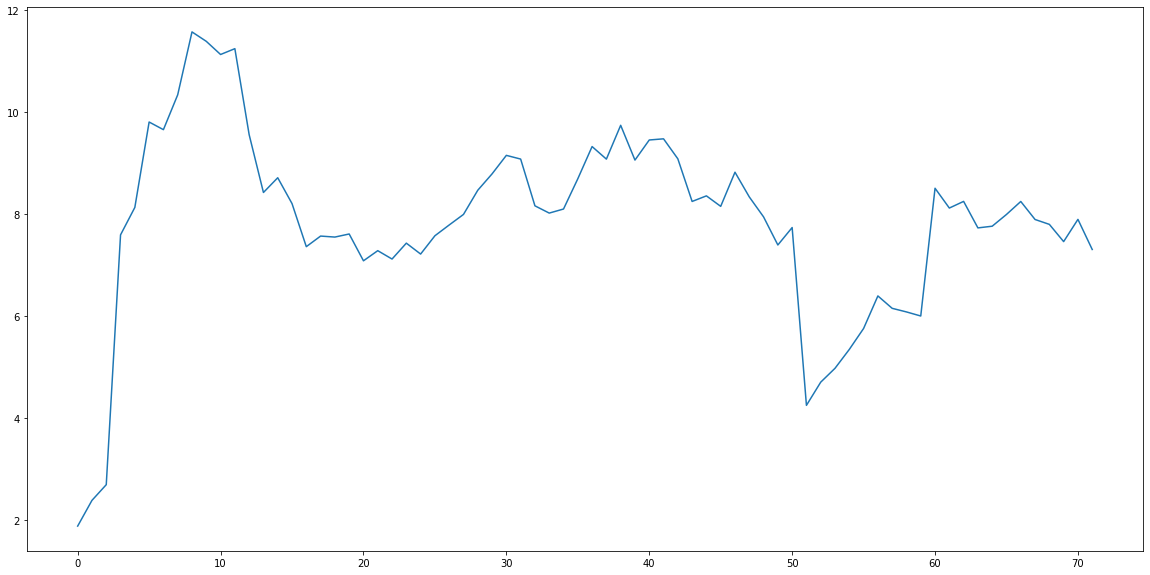

In [87]:

errors_df = pd.DataFrame(np.array(np.abs(errors)))
plt.figure(figsize=(20,10))
plt.plot(errors_df.mean())


No se vé una marcada relacion entre cantidad de pasos a futuros a predecir y el error obetenido, por lo que no podemos concluir qué si limitamos la cantidad de pasos a predecir, tengamos menor error. 

Quizás a partir de 2 pasos a futuro (horas en este caso) crece muy fuertemente el error, pero despues disminuye nuevamente.


### Humedad

Repetiremos el proceso anterior pero para evaluar el modelo entrenado en la prediccion de _humedad_

Para ello el primer paso es leer el modelo correspondiente que en este caso es otro archivo `.model` distinto.

In [2]:
model_package_name = '../models/esp:100_eps:1000_loss:mean_squared_error_opt:adam_pstps:24_sensor:A620_var:humidity_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-05-11_01:14:07.model'

with open(model_package_name, 'rb') as file_pi:
    model_package = pickle.load(file_pi)
    
model = model_package['model']
print(model.summary())

print('Input shape del modelo {}'.format(model.input_shape))
print('Output shape del modelo {}'.format(model.output_shape))



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 24, 48)            9600      
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 48)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 48)            18624     
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 48)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 48)            18624     
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 48)            0         


Luego leemos y procesamos los datos de manera analoga a como lo hicimos con la temperatura, pero ahora usando el atributo de humedad.

In [3]:
dataframe_hum = read_time_series_from_db(sensor='A620',numeric_var='humidity',which_minutes=[0])
dataframe_hum.iloc[1500:1510]


Measurements to read from database for sensor A620 with query 
SELECT "stations_measurement"."id", "stations_measurement"."datetime", "stations_measurement"."station_id", "stations_measurement"."attributes" FROM "stations_measurement" WHERE "stations_measurement"."station_id" = 2
Dataset from database of shape (201600, 2)


,index,datetime,attributes,date,hr,minute,humidity,inme
6000,6864,2011-03-04 12:00:00+00:00,"{'pm25': 0.0, 'humidity': 85.0, 'pressure': 10...",2011-03-04,12,0,85.0,A620
6004,6868,2011-03-04 13:00:00+00:00,"{'pm25': 0.0, 'humidity': 81.0, 'pressure': 10...",2011-03-04,13,0,81.0,A620
6008,6872,2011-03-04 14:00:00+00:00,"{'pm25': 0.0, 'humidity': 82.0, 'pressure': 10...",2011-03-04,14,0,82.0,A620
6012,6876,2011-03-04 15:00:00+00:00,"{'pm25': 0.8, 'humidity': 81.0, 'pressure': 10...",2011-03-04,15,0,81.0,A620
6016,6880,2011-03-04 16:00:00+00:00,"{'pm25': 0.0, 'humidity': 70.0, 'pressure': 10...",2011-03-04,16,0,70.0,A620
6020,6884,2011-03-04 17:00:00+00:00,"{'pm25': 0.8, 'humidity': 68.0, 'pressure': 10...",2011-03-04,17,0,68.0,A620
6024,6888,2011-03-04 18:00:00+00:00,"{'pm25': 0.0, 'humidity': 66.0, 'pressure': 10...",2011-03-04,18,0,66.0,A620
6028,6892,2011-03-04 19:00:00+00:00,"{'pm25': 0.0, 'humidity': 82.0, 'pressure': 10...",2011-03-04,19,0,82.0,A620
6032,6896,2011-03-04 20:00:00+00:00,"{'pm25': 0.8, 'humidity': 88.0, 'pressure': 10...",2011-03-04,20,0,88.0,A620
6036,6900,2011-03-04 21:00:00+00:00,"{'pm25': 0.0, 'humidity': 91.0, 'pressure': 10...",2011-03-04,21,0,91.0,A620


Extraemos la humedad y la transformamos en una serie temporal

In [6]:
time_series_dset = get_interest_variable(dataframe_hum, 'inme','date', 'hr','humidity','A620')
time_series_dset.iloc[1500:1510]

humidity
date       hr          
2011-03-04 12      85.0
           13      81.0
           14      82.0
           15      81.0
           16      70.0
           17      68.0
           18      66.0
           19      82.0
           20      88.0
           21      91.0

Transformamos la serie temporal en datapoints de manera que cada uno tenga el valor más reciente y los 24 valores anteriores.

In [7]:
scaler = model_package['scaler']

past_steps_train = model.input_shape[1]

# obtenemos los valores como una matriz
values = time_series_dset.values
# ensure all data is float
values = values.astype('float32')

scaled = scaler.transform(values)
scaled = pd.DataFrame(scaled,columns=time_series_dset.columns)# frame as supervised learning

reframed = series_to_supervised(scaled, past_steps_train, 1)
reframed.iloc[1000:1005]


,humidity_t-24,humidity_t-23,humidity_t-22,humidity_t-21,humidity_t-20,humidity_t-19,humidity_t-18,humidity_t-17,humidity_t-16,humidity_t-15,...,humidity_t-9,humidity_t-8,humidity_t-7,humidity_t-6,humidity_t-5,humidity_t-4,humidity_t-3,humidity_t-2,humidity_t-1,humidity_t
1024,0.452217,0.442365,0.471921,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,...,0.008867,0.008867,0.008867,0.008867,0.619704,0.540887,0.442365,0.008867,0.412808,0.402956
1025,0.442365,0.471921,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,...,0.008867,0.008867,0.008867,0.619704,0.540887,0.442365,0.008867,0.412808,0.402956,0.393103
1026,0.471921,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,...,0.008867,0.008867,0.619704,0.540887,0.442365,0.008867,0.412808,0.402956,0.393103,0.402956
1027,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,...,0.008867,0.619704,0.540887,0.442365,0.008867,0.412808,0.402956,0.393103,0.402956,0.462069
1028,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,0.008867,...,0.619704,0.540887,0.442365,0.008867,0.412808,0.402956,0.393103,0.402956,0.462069,0.501478


Luego vamos a predecir sobre muestras de de la base de datos a ver como funciona este modelo. 

Sampleamos datasets de futuro a pasado
(30225, 24) 30225 (30225,)
(30225, 24, 1) (30225,) (10075, 24, 1) (10075,) (10076, 24, 1) (10076,)
MAE : 20.26561254925198 - MaxE : 38.89812469482422 - Index of MaxE : 11
MAE : 15.247622648874918 - MaxE : 37.20968246459961 - Index of MaxE : 10
MAE : 20.093360159132217 - MaxE : 39.2918586730957 - Index of MaxE : 10
MAE : 12.74245292155279 - MaxE : 63.88838458061218 - Index of MaxE : 10
MAE : 17.80700813399421 - MaxE : 60.22579383850098 - Index of MaxE : 42
MAE : 28.066569805145264 - MaxE : 61.85847091674805 - Index of MaxE : 69
MAE : 14.90549405415853 - MaxE : 37.83245849609375 - Index of MaxE : 11
MAE : 18.212214549382526 - MaxE : 55.12459754943848 - Index of MaxE : 66
MAE : 26.33281832271152 - MaxE : 68.95702362060547 - Index of MaxE : 46
MAE : 39.09025243152347 - MaxE : 82.72978973388672 - Index of MaxE : 71


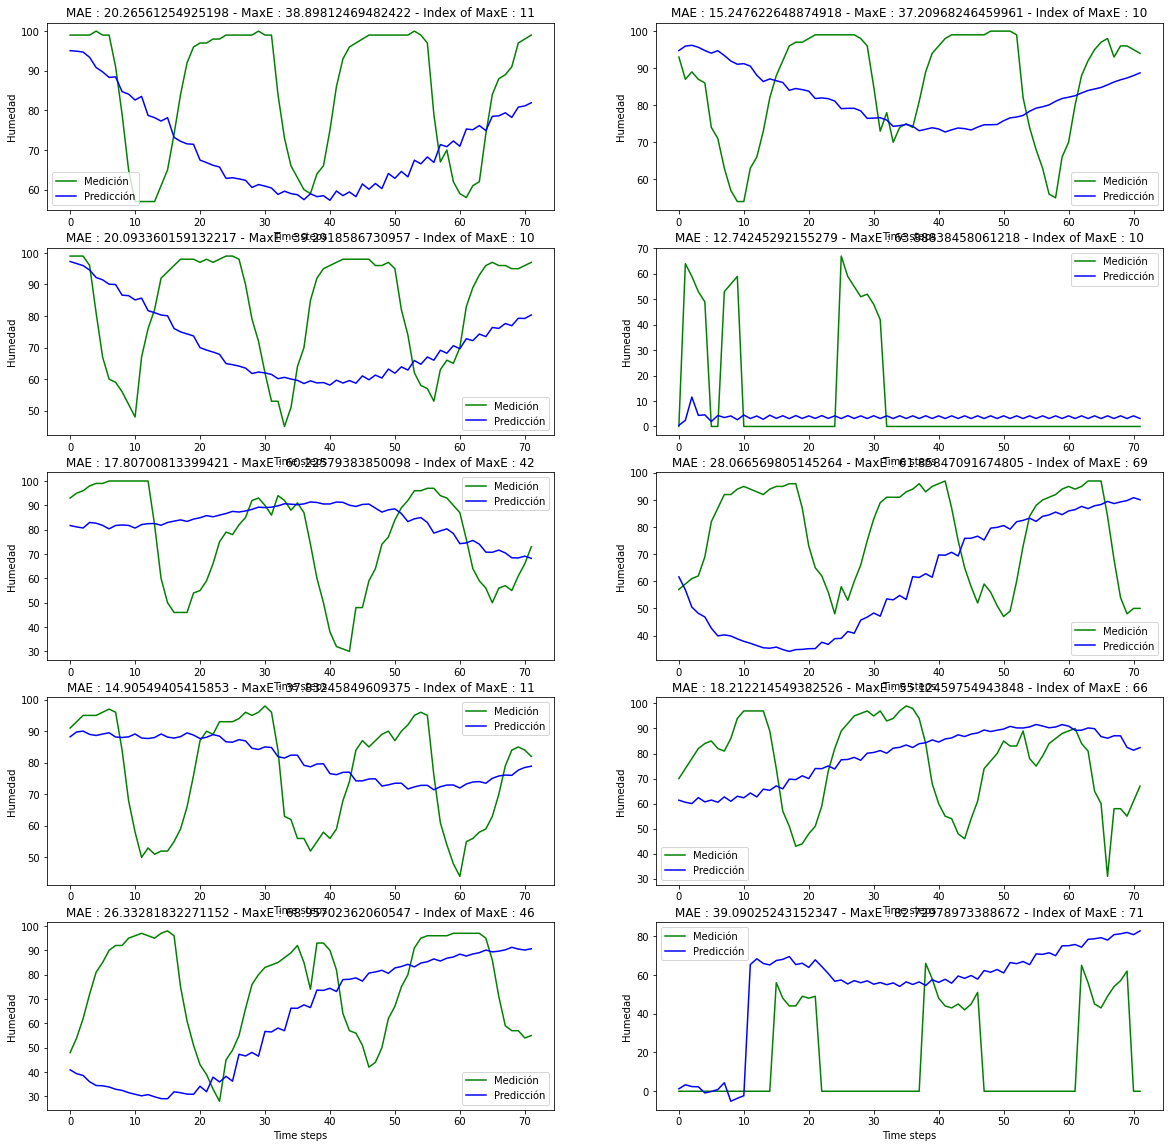

In [8]:
# particionar el dataset en trainset , validation set y test set
dataset_splits = train_val_test_split(reframed, past_steps_train,1, 'humidity')


# usaremos el trainset
dset = dataset_splits['testset']

# del trainset extraemos las entradas X y salidas y
X = dset['X']
y = dset['y']

# vamos a predecir al futuro 72 horas
future_steps = 72

# acumulamos los errores medio y maximo
maes = []
maxes = []
errors = []

# TODO esto deberia ser una grilla de subplots o algo asi

rows = 5 
cols = 2
n = rows * cols
fig, axs = plt.subplots(rows, cols,figsize=(20,20))
# vamos a hacer n muestras al azar y predecir sobre ellas 
for row in range(rows):
    for col in range(cols):
        i = np.random.randint(0,X.shape[0]-future_steps-1)
        try:
            # obtener el datpoints
            datapoint = X[i,:,:]

            # obtenemos el valor real pero des-escalado
            true = scaler.inverse_transform(y[i:i+future_steps].reshape(1,future_steps))

            # aplicamos el predictor sobre el datapoint
            preds,_ = predict_with_model(datapoint,model_package_name,future_steps)

            pred_list = []
            for step in preds:
                pred_list.append(np.float64(step[0][0]))
            pred = np.array([pred_list])

            # obtenemos los errores
            error = pred - true
            errors.append(error[0])

            mae_ = mean_absolute_error(true[0],pred[0])
            maes.append(mae_)
            maxe_ = max_error(true[0],pred[0])
            maxes.append(maxe_)
            max_error_index = np.argmax(error[0])

            msg = 'MAE : {} - MaxE : {} - Index of MaxE : {}'.format(mae_,maxe_,max_error_index)
            
            # ploteamos el valor verdadero en verde y el predecido en azul
            #plt.figure()
            the_ax = axs[row,col]
            the_ax.plot(range(true.shape[1]),true[0],'g',label='Medición')
            the_ax.plot(range(pred.shape[1]),pred[0],'b',label='Predicción')
            the_ax.set_title(msg)
            the_ax.legend()
            the_ax.set_xlabel('Time steps')
            the_ax.set_ylabel('Humedad')
            #axs[row,col].show()
    
            print(msg)
        except Exception as e:
            print('Exception {}'.format(e))


In [9]:
print('MAE promedio : {} '.format(np.mean(maes)))
print('MAE máximo : {} '.format(np.max(maes)))
print('Error maximo promedio : {} '.format(np.mean(maxes)))
print('Máximo Error maximo : {} '.format(np.max(maxes)))


MAE promedio : 21.27634055757274 
MAE máximo : 39.09025243152347 
Error maximo promedio : 54.60161845684051 
Máximo Error maximo : 82.72978973388672 


Para este caso los errores absolutos médios y los máximos son muy grandes.

Veremos luego como evoluciona el error máximo a medida que intentamos predecir más pasos hacia adelante.


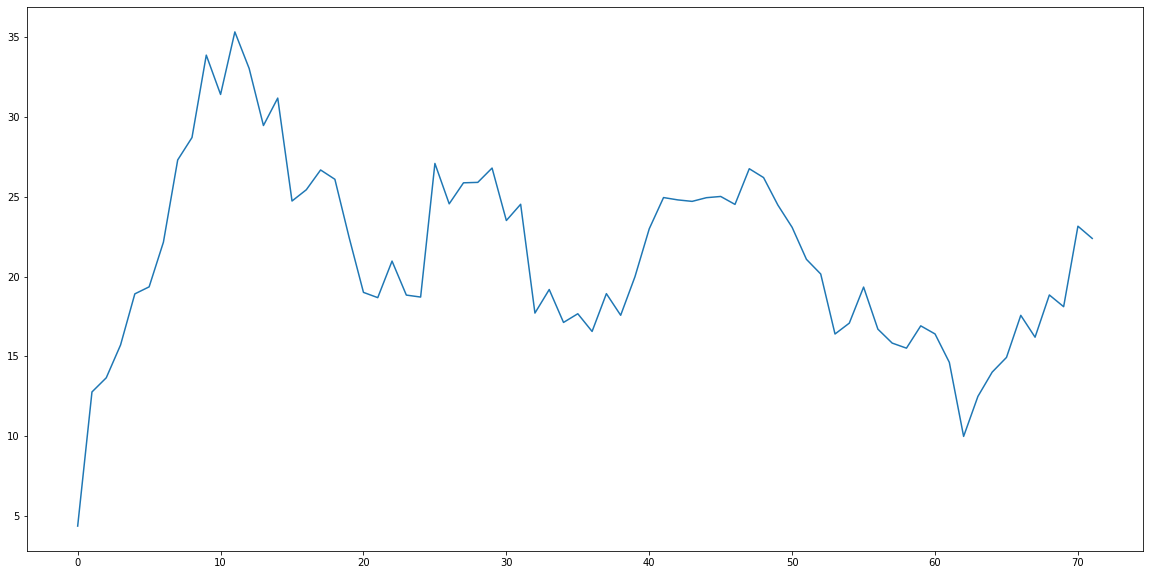

In [10]:
errors_df = pd.DataFrame(np.array(np.abs(errors)))
plt.figure(figsize=(20,10))
plt.plot(errors_df.mean())

Se observa que apenas empezamos el error máximo se dispara para los primeros pasos, por lo que quizas lo mejor sea solo confiar en las predicciones para los primeros 5 pasos adelante donde se ve que el error n osupera los 20 puntos

### Prediciendo en producción

Una vez que tenemos modelos entrenados, podemos usarlos para predecir sobre las ultimas mediciones de la base de datos (modelo `Measurement`). Para ello usamos el comando `predict_lstm` el cual puede ser configurado para ser ejecutado periodicamente y así mantener la base de datos actualizada. 

Para ejecutar el comando se debe hacer lo siguiente:
1. Ubicarse en la carpeta raíz del proyecto  `satlomas-back`
2. Para correrlo en background podemos ejecutar 

```
nohup python manage.py predict_lstm archivo_de_configuracion.json 'models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_23:09:03.model' 24 60 >> log_predicciones.log 2>&1 &
```
    
El primer parametro de este comando es el **MISMO** archivo de configuración usado para entrenar el modelo que usaremos, el cual describimos anteriormente.

El segundo parámetro es la ruta al modelo que quisieramos usar para predecir y fue generado con el archivo de configuración pasado como primer parametro.

Luego indicamos con un número entero cuantos pasos hacia adelante queremos realizar predicciones y el último parametro indica cuantos mínutos hay en un `time_step`. Es decir que para el ejemplo anterior vamos a predecir 24 periodos adelante y cada periodo será de 60 minutos por lo que iremos un día adelante. Este ultimo valor debe corresponderse con el sampleo usado para entrenar, por lo que si para entrenar el periodo de tiempo considerado para cada `time_step` fue de una hora, aqui ponemos 60. Si hubiesemos usado muestras cada 15 minutos aqui iria el numero 15. 


Como resultado de ejecutar este comando deberiamos tener en la base de datos  tantos registros en la tabla de `Prediction` como pasos generemos. Cada registro tiene el mismo formato que las `Measurement` solo que referencia predicciones, es decir valores obtenidos con el modelo, y no reales. Además este comando al ser ejecutado, si encuentra una prediccion anterior para el mismo momento en el tiempo, la actualiza con la nueva prediccion.


## Analizando las predicciones de la base de datos

A continuación presentaremos de forma gráfica las predicciones realizadas por el comando de prediccion y alamacenadas en la base de datos tomando información de la ultima medición registrada

Para este caso no podremos ver el valor real ya que efectivamente se tomaron los ultimos datapoints de medicion para generar datos a futuro para los cuales no hay datos reales ya que estamos trabajando con datos simulados y extraidos de otro problema. En producción este comando leera cada un cierto tiempo las ultimas mediciones, realizará las predicciones y las almacenará en la base de datos.


Buscamos en primer lugar en la base de datos usando los modelos django las predicciones y extraemos temperatura y humedad en un dataframe

In [11]:

predictions_df = get_database_data(numeric_vars = ['temperature','humidity'])
print(predictions_df.shape)
if predictions_df.shape[0] > 0 :
    predictions_df.sort_values('datetime',ascending = True,inplace = True)
    predictions_df.set_index('datetime',inplace=True)
predictions_df

(168, 8)


,index,attributes,date,hr,minute,temperature,humidity
datetime,,,,,,,
2016-10-01 00:45:00+00:00,90,"{'pm25': 0, 'humidity': 90.10526275634766, 'pr...",2016-10-01,0,45,19.003529,90.105263
2016-10-01 01:45:00+00:00,0,"{'pm25': 0, 'humidity': 89.9897689819336, 'pre...",2016-10-01,1,45,18.709032,89.989769
2016-10-01 02:45:00+00:00,1,"{'pm25': 0, 'humidity': 90.89995574951172, 'pr...",2016-10-01,2,45,19.618797,90.899956
2016-10-01 03:45:00+00:00,2,"{'pm25': 0, 'humidity': 89.60636138916016, 'pr...",2016-10-01,3,45,18.079092,89.606361
2016-10-01 04:45:00+00:00,3,"{'pm25': 0, 'humidity': 90.11933898925781, 'pr...",2016-10-01,4,45,19.048353,90.119339
...,...,...,...,...,...,...,...
2016-10-07 19:45:00+00:00,163,"{'pm25': 0, 'humidity': 72.91453552246094, 'pr...",2016-10-07,19,45,19.229179,72.914536
2016-10-07 20:45:00+00:00,164,"{'pm25': 0, 'humidity': 73.91715240478516, 'pr...",2016-10-07,20,45,20.346392,73.917152
2016-10-07 21:45:00+00:00,165,"{'pm25': 0, 'humidity': 75.32521057128906, 'pr...",2016-10-07,21,45,19.949116,75.325211


Tambien buscamos hacia el pasado las mediciones realizadas

In [16]:
past_days = 15
last_n_steps = past_days * 24 * 4
measurement_df = get_database_data(Measurement,numeric_vars = ['temperature','humidity'],last_n_steps=last_n_steps)
measurement_df.sort_values('datetime',ascending = True,inplace = True)
measurement_df.set_index('datetime',inplace=True)
measurement_df.query('minute == 45').tail(10)

,index,attributes,date,hr,minute,temperature,humidity
datetime,,,,,,,
2016-09-30 14:45:00+00:00,36,"{'pm25': -0.9, 'humidity': 71.1, 'pressure': 1...",2016-09-30,14,45,21.7,71.1
2016-09-30 15:45:00+00:00,32,"{'pm25': -0.9, 'humidity': 79.1, 'pressure': 1...",2016-09-30,15,45,20.7,79.1
2016-09-30 16:45:00+00:00,28,"{'pm25': -0.9, 'humidity': 84.1, 'pressure': 1...",2016-09-30,16,45,19.6,84.1
2016-09-30 17:45:00+00:00,24,"{'pm25': -0.9, 'humidity': 77.1, 'pressure': 1...",2016-09-30,17,45,20.2,77.1
2016-09-30 18:45:00+00:00,20,"{'pm25': -0.9, 'humidity': 74.1, 'pressure': 1...",2016-09-30,18,45,20.6,74.1
2016-09-30 19:45:00+00:00,16,"{'pm25': -0.9, 'humidity': 80.1, 'pressure': 1...",2016-09-30,19,45,19.8,80.1
2016-09-30 20:45:00+00:00,12,"{'pm25': -0.9, 'humidity': 76.1, 'pressure': 1...",2016-09-30,20,45,20.2,76.1
2016-09-30 21:45:00+00:00,8,"{'pm25': -0.5, 'humidity': 87.1, 'pressure': 1...",2016-09-30,21,45,18.5,87.1
2016-09-30 22:45:00+00:00,4,"{'pm25': -0.9, 'humidity': 89.1, 'pressure': 1...",2016-09-30,22,45,18.5,89.1


Luego plotearemos las mediciones pasadas en un color junto con las predicciones en otro

En primer lugar para la temperatura

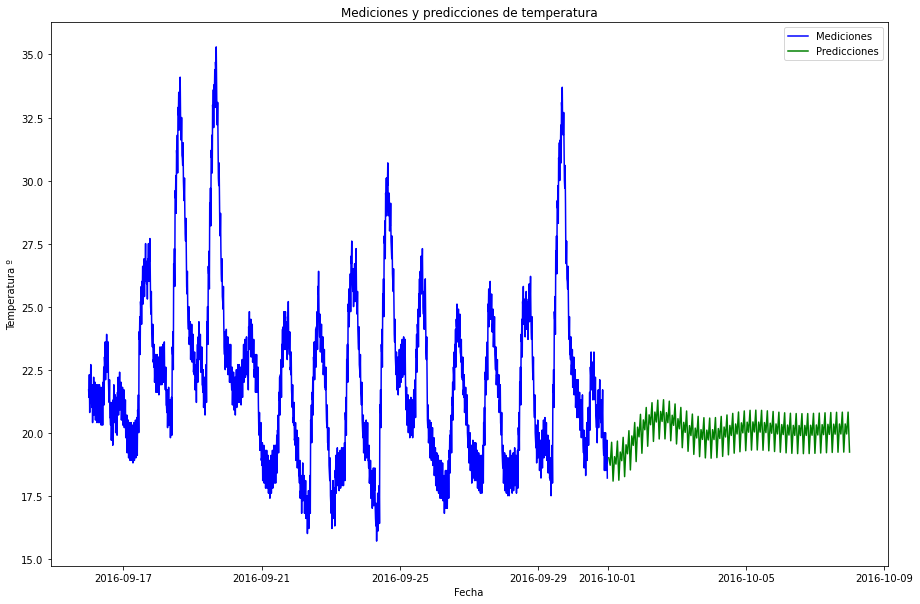

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize = (15,10))
plt.plot(measurement_df.temperature,color='blue',label='Mediciones')
if predictions_df.shape[0] > 0 :
    plt.plot(predictions_df.temperature,color='green',label='Predicciones')

plt.title('Mediciones y predicciones de temperatura')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Temperatura º')

plt.show()

Como se ve en la prediccion anterior, luego de aproximadamente 4 a 5 días las predicciones realmente empiezan a estancarse por lo que no sería recomendable usarlos hasta tal punto. No podemos validar esto ya que no tenemos mediciones para fechas en la zona de la linea verde. 

Veremos el mismo grafico para la humedad


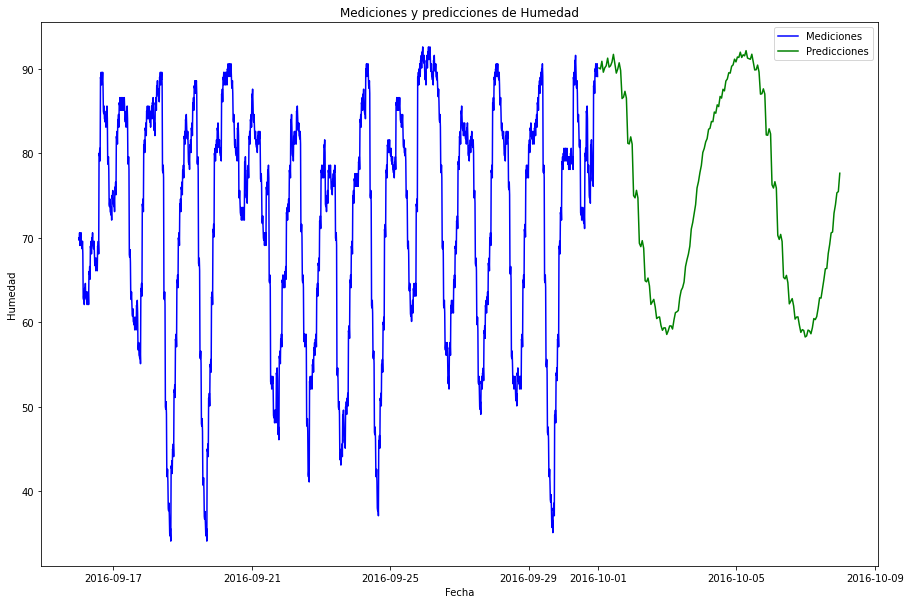

In [18]:

plt.figure(figsize = (15,10))
plt.plot(measurement_df.humidity,color='blue',label='Mediciones')
if predictions_df.shape[0] > 0 :
    plt.plot(predictions_df.humidity,color='green',label='Predicciones')

plt.title('Mediciones y predicciones de Humedad')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Humedad')

plt.show()

Interesantemente las predicciones de humedad siguen un patrón similar a las mediciones que se ven hacia atrás. 

Se observa que también las predicciones no superan el maximo historico, lo que tiene sentido. 

## Ideas de mejora

### Modelo con entrada y salida multi-variada

Una de las mejoras a realizar es poder entrenar un único modelo por estación, que sirva para predecir todas las medidas meteorológicas de una vez. Actualmente para cada medida (temperatura, humedad, etc...) se debe entrenar un modelo ya que la entrada del mismo es univariada y solo toma un valor para varios pasos hacia atrás. 

Un proximo paso entonces seria entrenar el modelo incorporando en cada time step todas las mediciones como parte del vector además de quizas incorporár información de contexto como hora del día, minuto de la hora, e incluso el més. Esta mejora además del beneficio de tener solo un modelo por estación puede llegar a producir menores errores ya que las mediciones pueden estar influenciandose entre ellas. 


### Predicción directa de más de un paso en el futuro

Actualmente, el modelo predice solo un paso adelante por lo que para predecir más al futuro tomamos ese resultado y lo usamos como parte de un nuevo datapoint. Aqui estámos confiando en la predicción hecha para usarla como entrada y podemos estar propagando errores si en algun punto nuesstras predicciones se devían. La propuesta sería que la salida de la red neuronal no sea un solo paso hacia adelante si no que definamos mayor tiempo hacia adelante para predecir.